<a href="https://colab.research.google.com/github/ioannispartalas/CrossLingual-NLP-AMLD2020/blob/master/LASER_cross_language_embd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross lingual processing and Transfer Learning using multi-linguale embedding

Facebook AI has released a multilingual toolkit called LASER (Language-Agnostic SEntence Representations) relying on sequence to sequence autoencoder. Sequence encoder has the undisputable advantage to process directly language sentences and thus apture their internal structures.

LASER has been trained over more than 100 languages which permits to project through the encoder any sentences from those languages in a common representation, called multi-lingual embedding  space.
<figure>
<img src= "https://engineering.fb.com/wp-content/uploads/2019/01/CodeBlog_embedding_space_v4.png" style= "width=45%">
 <figcaption>Fig.1 - Multinlingual embedding.</figcaption>
</figure>

On this notebook, we will work on a multilingual dataset containing sentences in four languages: english, dutch, spanish and russian. Every sentence of every language comes along a with sentiment label indicating positive or negative content. There is no sentence overlapp between idioms. We directly provide the sentence embedding for all langauges. Every sentence is represented by a 1024 dimensional vector indicating its position in LASER.

In [1]:
#Let's download the dataset
!git clone https://github.com/ioannispartalas/CrossLingual-NLP-AMLD2020.git
#Data are in copied in ./CrossLingual-NLP-AMLD2020/data/laser/ of your colab local filesystem
!ls ./CrossLingual-NLP-AMLD2020/data/laser/

Cloning into 'CrossLingual-NLP-AMLD2020'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 80 (delta 30), reused 33 (delta 9), pack-reused 0
Unpacking objects: 100% (80/80), done.
en_laser_test.npy	  es_test_labels_adan.txt   ru_laser_test.npy
en_laser_train.npy	  es_train_labels_adan.txt  ru_laser_train.npy
en_test_labels_adan.txt   nl_laser_test.npy	    ru_test_labels_adan.txt
en_train_labels_adan.txt  nl_laser_train.npy	    ru_train_labels_adan.txt
es_laser_test.npy	  nl_test_labels_adan.txt
es_laser_train.npy	  nl_train_labels_adan.txt


The dataset is made of numpy files:
```
'en_laser_train.npy'
'en_laser_test.npy'
'nl_laser_test.npy'
...
```
containing respectively training and test set for every language. 

Corresponding labels are stored in 
```
en_train_labels_adan.txt
en_test_labels_adan.txt
nl_laser_train.npy
...
```


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import random as rn

In [0]:
np.random.seed(12)
rn.seed(1236)
tf.set_random_seed(1234)

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def matthews(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    mcc = (tp*tn - fp*fn) / K.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mcc = tf.where(tf.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return K.mean(mcc)
    
def set_model(dims,l2_reg):
  model =keras.Sequential()
  model.add(keras.layers.Input(shape = (1024,)))
  for d in dims:
      model.add(keras.layers.Dense(d,activation = 'relu',kernel_regularizer = keras.regularizers.l2(l2_reg)))
  model.add(keras.layers.Dense(2,activation = 'softmax', kernel_regularizer = keras.regularizers.l2(l2_reg)))
  model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=[f1])
  return model



In [0]:
def load_data(lang, train_or_test):
    path = './CrossLingual-NLP-AMLD2020/data/laser/'
    feat_fn =  path  + lang + '_laser_' + train_or_test + '.npy'
    label_fn = path  + lang + '_' + train_or_test + '_labels_adan.txt'
    labels = np.loadtxt(label_fn) 
    kk = np.squeeze(np.where(labels != 2))
    feat = np.load(feat_fn)[kk]
    labels = keras.utils.to_categorical(labels[kk]-1,3)[:,[0,2]]
    return feat,labels

def load_language(lang):
  train_feat, train_labels = load_data(lang,'train')
  test_feat, test_labels = load_data(lang,'test')
  return train_feat,train_labels,test_feat,test_labels

def cross_lang_evaluation(model):
  languages = ['nl','en','es','ru']
  A = {}
  for lang in languages:
    x_test,y_test = load_data(lang, 'test')
    _, acc = model.evaluate(x_test, y_test, batch_size=x_test.shape[0],verbose = 0)
    A[lang] = acc
  return A



In [0]:
x_train,y_train,x_test,y_test = load_language('en')  
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience =50)
reg = np.logspace(-6,-3,4)
acc = []
for l2 in reg:
  model = set_model([],l2)
  history = model.fit(x_train, y_train,
            epochs=20000,
            batch_size=16,
            verbose =0,
            validation_split = 0.2,
            callbacks = [es])
  a = history.history['val_f1'][len(history.history['val_f1'])-49]
  acc.append( (a,l2,model,history))


Epoch 00167: early stopping
Epoch 00158: early stopping


In [0]:
print(acc)

In [0]:
print(history.history.keys())
print(np.max(history.history['val_f1']))
print(history.history['val_f1'][len(history.history['val_f1'])-49])

In [0]:
mx = max([v for v,_,_,_ in acc])
final_reg = [r for v,r,_,_ in acc if v ==mx][0]
final_model = [model for v,_, model,_ in acc if v ==mx][0]
final_history = [h for v,_, _,h in acc if v ==mx][0]
print(final_reg,mx)

[[382  39]
 [ 44  91]]


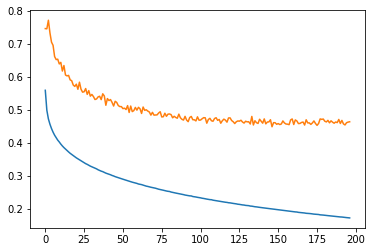

In [0]:
import matplotlib.pyplot as plt
plt.plot( final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
print(confusion_matrix(np.argmax(y_test,axis =1),model.predict_classes(x_test)))

In [0]:
A = cross_lang_evaluation(final_model)
print(A)

{'nl': 0.8075324, 'en': 0.79332423, 'es': 0.8080615, 'ru': 0.8138392}


In [0]:
x_train =[]
y_train =[]
x_test =[]
y_test =[]
for lang in languages:
  x_tr,y_tr,x_te,y_te = load_language(lang)  
  x_train.append(x_tr)
  y_train.append(y_tr)
  x_test.append(x_te)
  y_test.append(y_te)


x_train =np.vstack(x_train)
y_train =np.vstack(y_train)
x_test =np.vstack(x_test)
y_test =np.vstack(y_test)

In [0]:
for l2 in reg:
  model = set_model([],l2)
  history = model.fit(x_train, y_train,
            epochs=20000,
            batch_size=16,
            verbose =0,
            validation_split = 0.2,
            callbacks = [es])
  a = history.history['val_f1'][len(history.history['val_f1'])-49]
  acc.append( (a,l2,model,history))


Epoch 00208: early stopping
Epoch 00221: early stopping
Epoch 00211: early stopping
Epoch 00191: early stopping


In [0]:
mx = max([v for v,_,_,_ in acc])
final_reg = [r for v,r,_,_ in acc if v ==mx][0]
final_model = [model for v,_, model,_ in acc if v ==mx][0]
final_history = [h for v,_, _,h in acc if v ==mx][0]
print(final_reg,mx)

0.001 0.7974188


0.83828664


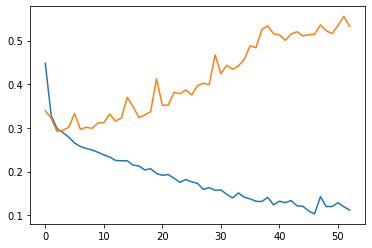

In [0]:
import matplotlib.pyplot as plt
plt.plot( final_history.history['loss'])
plt.plot(final_history.history['val_loss'])

x_test, y_test = load_data('en','test')
_,macro_f1 = model.evaluate(x_test, y_test, batch_size=x_test.shape[0],verbose = 0)
print(macro_f1)

In [0]:
print (acc)

[(0.745152, 1e-06, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc4586128>, <tensorflow.python.keras.callbacks.History object at 0x7fdbc4570128>), (0.74961734, 1e-05, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc484a198>, <tensorflow.python.keras.callbacks.History object at 0x7fdbc44b6048>), (0.7478022, 0.0001, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc44b6470>, <tensorflow.python.keras.callbacks.History object at 0x7fdbc43ee198>), (0.7471888, 0.001, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc43ee710>, <tensorflow.python.keras.callbacks.History object at 0x7fdbc433f2b0>), (0.7830908, 1e-06, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc41da400>, <tensorflow.python.keras.callbacks.History object at 0x7fdbc41eaf28>), (0.7921606, 1e-05, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdbc418c9b0>, <tensorflow.python.keras.callbacks.History 